In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import networkx as nx
import pandas as pd

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split, StaticGraphTemporalSignal

from haversine import haversine

# GPU support
DEVICE = torch.device('cuda:3') # cuda
shuffle=True
batch_size = 32

In [2]:
class AirQualityDataset():
    def __init__(self, path, features=None, lat_long_vals=None, t_range=None, time_zone=None,  interval='hour', eq_weights=True):
        self.eq_weights = eq_weights
        self.interval = interval
        
        df = pd.read_csv(path)
        df['time'] = pd.to_datetime(df['time'], utc=True)
        df['locationLatitude'] = df['locationLatitude'].round(6)
        df['locationLongitude'] = df['locationLongitude'].round(6)
        cols_to_keep = ['time', 'locationLatitude', 'locationLongitude'] + list(features.keys())

        if features:
            df = df[cols_to_keep]
        if time_zone:
            df.time = df.time.dt.tz_convert(time_zone)
        if t_range:
            df = df[(df['time'] > t_range[0]) & (df['time'] < t_range[1])]
        if not lat_long_vals.empty:
            df = df.merge(lat_long_vals, on=['locationLatitude', 'locationLongitude'])

        fin_df = df.groupby(['locationLatitude', 'locationLongitude', pd.Grouper(key='time', freq='h')]).agg(features).reset_index()
        fin_df['hour'] = fin_df['time'].dt.hour
        self.locations = fin_df[['locationLatitude', 'locationLongitude']].drop_duplicates()
        self.dataset = fin_df
        # self.length = min(fin_df.groupby(['locationLatitude', 'locationLongitude']).size())
    
    def _get_edge_weights(self):
        num_nodes = len(self.locations)
        self.mapper = {i: tuple(self.locations.iloc[i]) for i in range(num_nodes)}
        self.rev_map = {tuple(self.locations.iloc[i]): i for i in range(num_nodes)}

        edges = []
        weights = []

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                dist = haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j]))
                if dist != 0:
                    if self.eq_weights:
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(1)
                        weights.append(1)
                    else:
                        attr = 1 / (1 + haversine(tuple(self.locations.iloc[i]), tuple(self.locations.iloc[j])))
                        edges.append([i, j])
                        edges.append([j, i]) 
                        weights.append(attr)
                        weights.append(attr)

        self.edges = np.array(edges).T
        self.edge_weights = np.array(weights)

    def _get_task(self, start_pred):
        assert start_pred < 24 and start_pred > 1

        fin_df = self.dataset
        self.features = []
        self.targets = []

        # features is per day
        for day in list(pd.unique(fin_df['time'].dt.date)):
            loc_list = []
            day_df = fin_df[fin_df['time'].dt.date == day]
            
            # numpy array per location per hour
            # array shape: len(locs) x features x 24
            for lat, long in self.locations.itertuples(index=False):
                features_list = []
                loc_df = day_df[(day_df['locationLatitude'] == lat) & (day_df['locationLongitude'] == long)]
                if not loc_df.empty:
                    for hr in range(24):
                        vals = loc_df[loc_df['hour'] == hr]
                        if not vals.empty:
                            features_list.append(np.array(vals.iloc[0, 3:-1]))
                        else:
                            features_list.append(np.zeros(len(fin_df.columns[3:-1])))
                    features_list_np = np.stack(features_list).T
                else:
                    features_list_np = np.zeros((len(fin_df.columns[3:-1]), 24))
                    
                loc_list.append(features_list_np)
            
            fin_arr = np.stack(loc_list).astype('float64')
            self.features.append(fin_arr[:, :, :start_pred])
            self.targets.append(fin_arr[:, :, start_pred:])
    
    def get_dataset(self, start_pred=12):
        self._get_edge_weights()
        self._get_task(start_pred)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset

In [4]:
features = {
    'pm2_5ConcNumIndividual.value': 'mean',
}
lat_long_vals = pd.DataFrame({
    'locationLatitude': [-36.844079, -36.844113, -36.711932, -36.898491, -36.906652, -36.876728],
    'locationLongitude': [174.762123, 174.761371, 174.740808, 174.591428, 174.633079, 174.703081]
})
t_range = ['2022-04-01', '2022-12-01']
time_zone = 'Pacific/Auckland'

niwa_loader = AirQualityDataset('../../../AirData/Niwa/allNIWA_clarity.csv',
                                 features, lat_long_vals, t_range, time_zone, 'hour',
                                 False)

In [5]:
niwa_dataset = niwa_loader.get_dataset(12)

In [6]:
y = next(iter(niwa_dataset))

In [8]:
y

Data(x=[6, 1, 12], edge_index=[2, 30], edge_attr=[30], y=[6, 1, 12])

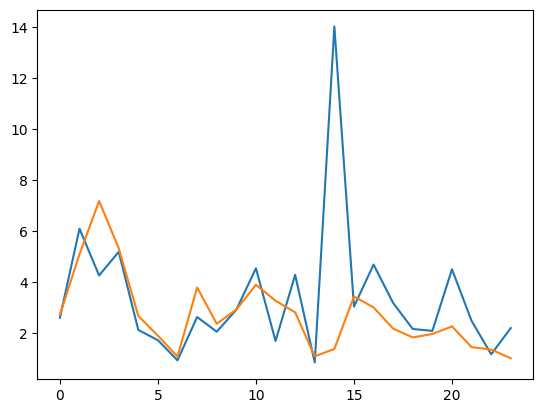

In [9]:
# Visualize traffic over time
sensor_number = 0
hours = 24
sensor_labels = [bucket.y[sensor_number][0][0].item() for bucket in list(niwa_dataset)[:hours]]
plt.plot(sensor_labels)

sensor_number = 3
hours = 24
sensor_labels = [bucket.y[sensor_number][0][0].item() for bucket in list(niwa_dataset)[:hours]]
plt.plot(sensor_labels)

# Test Train Split

In [10]:
train_dataset, test_dataset = temporal_signal_split(niwa_dataset, train_ratio=0.8)

# print("Number of train buckets: ", len(set(train_dataset)))
# print("Number of test buckets: ", len(set(test_dataset)))

In [11]:
train_input = np.array(train_dataset.features) # (195, 6, 4, 12)
train_target = np.array(train_dataset.targets) # (195, 6, 4, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, F*T)

train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [12]:
test_input = np.array(test_dataset.features) # (49, 6, 4, 12)
test_target = np.array(test_dataset.targets) # (49, 6, 4, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  

test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [13]:
test_target.shape

(49, 6, 1, 12)

In [14]:
test_target[0, 0, :, :]

array([[0.51      , 0.67      , 0.7       , 0.43      , 0.65666667,
        0.595     , 0.81      , 0.77      , 0.82666667, 1.73      ,
        2.02333333, 1.635     ]])

In [15]:
test_target_tensor[0, 0, :]

tensor([[0.5100, 0.6700, 0.7000, 0.4300, 0.6567, 0.5950, 0.8100, 0.7700, 0.8267,
         1.7300, 2.0233, 1.6350]], device='cuda:3')

# A3TGCN Model

In [16]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, out_size, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=512, periods=periods, batch_size=batch_size) # node_features=4, periods=12
        # Equals single-shot prediction
        self.linear1 = torch.nn.Linear(512, 256)
        self.linear2 = torch.nn.Linear(256, 128)
        self.linear3 = torch.nn.Linear(128, out_size)

    def forward(self, x, edge_index, edge_weights=None):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        if edge_weights is not None:
            h = self.tgnn(x, edge_index, edge_weights) # x [b, 6, 4, 12]  returns h [b, 6, 12*4]
        else:
            h = self.tgnn(x, edge_index)
        h = F.relu(self.linear1(h)) 
        h = F.relu(self.linear2(h)) 
        h = self.linear3(h)
        return h

TemporalGNN(node_features=4, periods=12, out_size=12*4, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(4, 512)
      (linear_z): Linear(in_features=1024, out_features=512, bias=True)
      (conv_r): GCNConv(4, 512)
      (linear_r): Linear(in_features=1024, out_features=512, bias=True)
      (conv_h): GCNConv(4, 512)
      (linear_h): Linear(in_features=1024, out_features=512, bias=True)
    )
  )
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=48, bias=True)
)

In [17]:

# Create model and optimizers
model = TemporalGNN(node_features=4, periods=12, out_size=12*4, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([512])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([512, 4])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([512, 1024])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([512])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([512])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([512, 4])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([512, 1024])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([512])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([512])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([512, 4])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([512, 1024])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([512])
linear1.weight 	 torch.Size([256, 512])
linear1.bias 	 torch.Size([256])
linear2.weight 	 torch.Size([128, 256])
linear2.bias 	 torch.Size([128])
linear3.weight 	 torch.Size([48, 128])
linear3.bias 	 torch.Size([48])
Net's total params: 1752508
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001

In [18]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    static_edge_weight = snapshot.edge_attr.to(DEVICE)
    break

In [19]:
static_edge_weight

tensor([0.2078, 0.2078, 0.1241, 0.1241, 0.0696, 0.0696, 0.0693, 0.0693, 0.0405,
        0.0405, 0.0891, 0.0891, 0.0579, 0.0579, 0.0577, 0.0577, 0.0390, 0.0390,
        0.1365, 0.1365, 0.1354, 0.1354, 0.0509, 0.0509, 0.9372, 0.9372, 0.0632,
        0.0632, 0.0632, 0.0632], device='cuda:3')

In [22]:
model.train()

for epoch in range(500):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        # print(encoder_inputs, static_edge_index.shape)
        y_true = torch.flatten(labels, start_dim=2) # (B, N, F*T)
        print(encoder_inputs.shape)
        y_hat = model(encoder_inputs, static_edge_index, static_edge_weight)         # Get model predictions
        loss = torch.sqrt(loss_fn(y_hat, y_true)) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

torch.Size([32, 6, 1, 12])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x1 and 4x512)

In [39]:
model.eval()
step = 0
# Store for analysis
total_loss = []
all_y_true = []
all_y_hat = []

for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_true_t = torch.flatten(labels, start_dim=2)
    y_hat_t = model(encoder_inputs, static_edge_index, static_edge_weight)
    # Mean squared error
    loss = torch.sqrt(loss_fn(y_hat_t, y_true_t))
    total_loss.append(loss.item())

    all_y_true.append(y_true_t)
    all_y_hat.append(y_hat_t)
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 5.5377


In [40]:
all_y_true = torch.cat(all_y_true, dim=0)
all_y_hat = torch.cat(all_y_hat, dim=0)

In [45]:
all_y_true = torch.unflatten(all_y_true, 2, (4, 12))
all_y_hat = torch.unflatten(all_y_hat, 2, (4, 12))

In [47]:
all_y_hat.shape

torch.Size([32, 6, 4, 12])

In [48]:
labels.shape

torch.Size([32, 6, 4, 12])

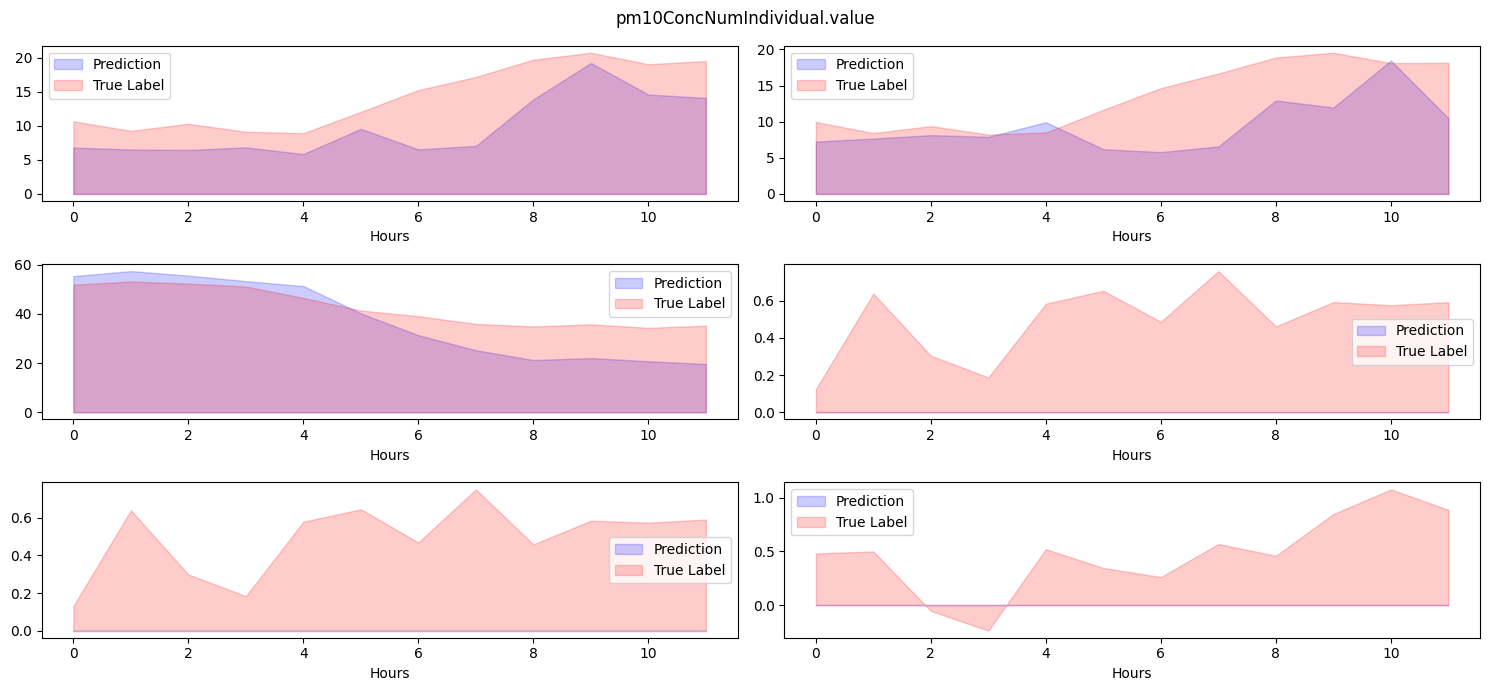

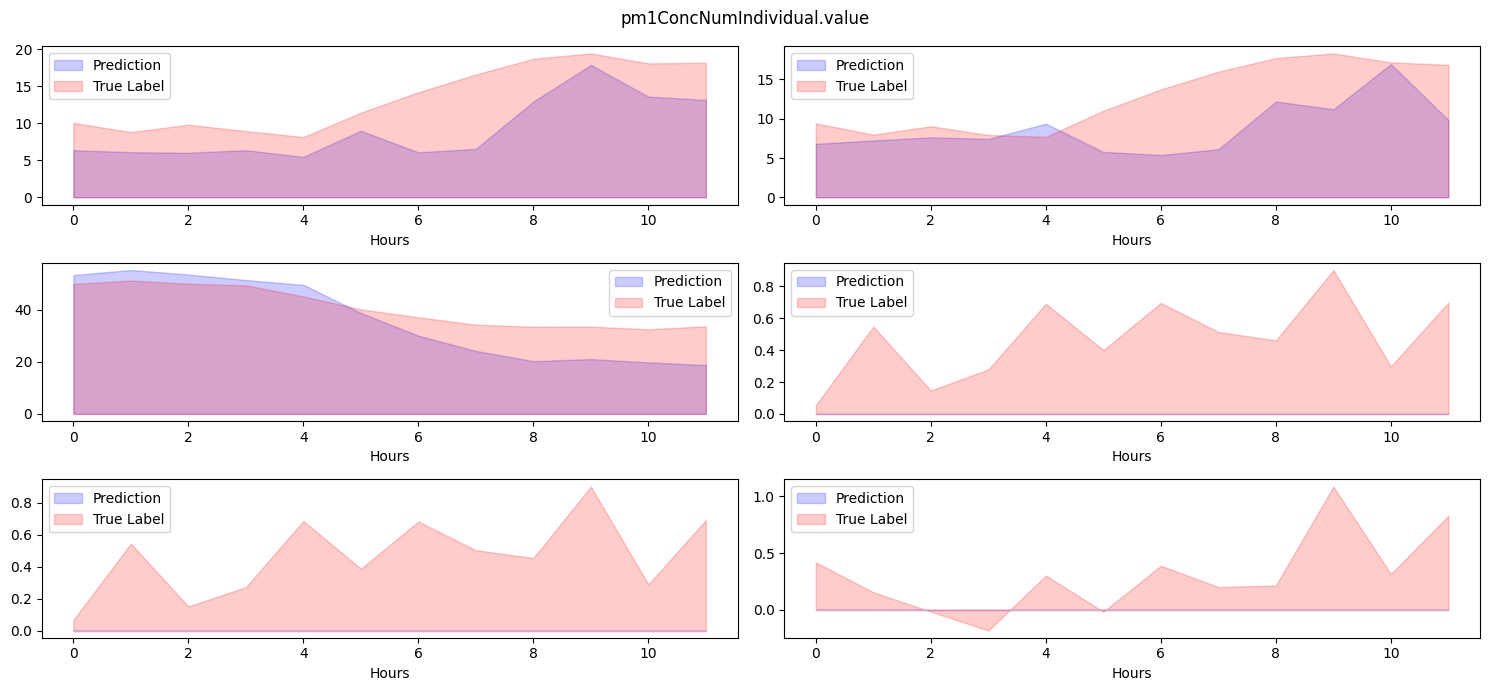

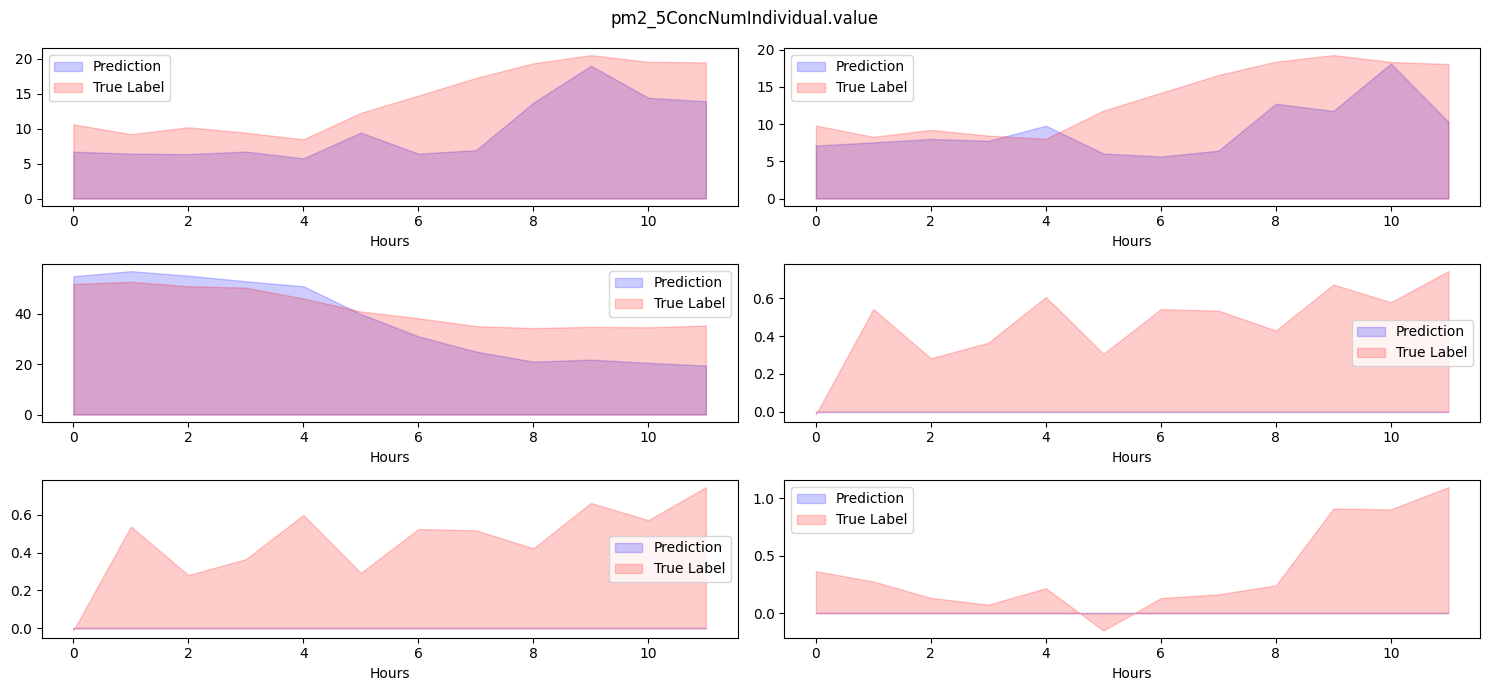

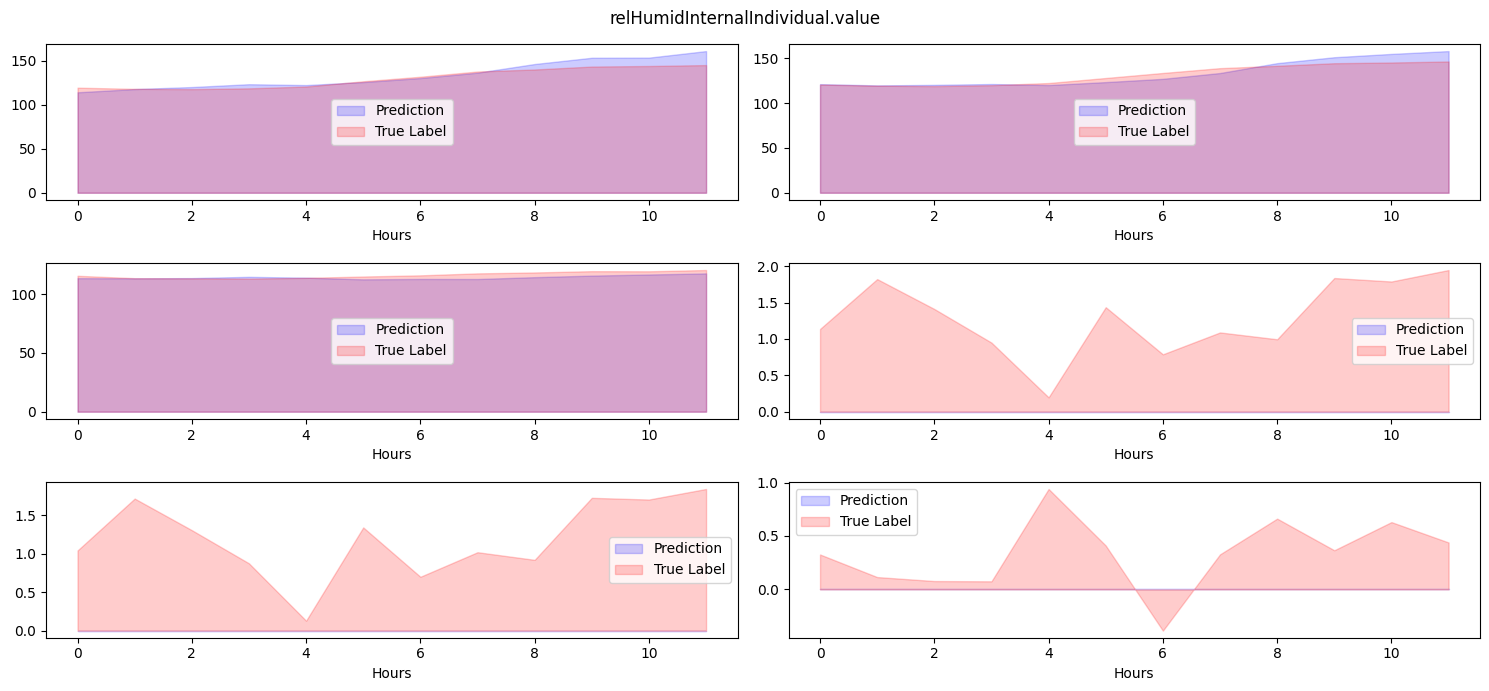

In [ ]:
feat = 2

def plot_features(feat):
    # all_y_true must be (B, N, F, T)
    preds = np.asarray(all_y_true[:, :, feat, :].detach().cpu().numpy())
    labs  = np.asarray(all_y_hat[:, :, feat, :].detach().cpu().numpy())

    fig, axs = plt.subplots(3, 2, figsize=(15,7))

    for i, ax in enumerate(axs.flatten()):
        p_mean_val = np.mean(preds[:, i, :], axis=0)
        p_std_val = np.mean(preds[:, i, :], axis=0)

        t_mean_val = np.mean(labs[:, i, :], axis=0)
        t_std_val = np.mean(labs[:, i, :], axis=0)

        ax.fill_between(range(12), p_mean_val - p_std_val, p_mean_val + p_std_val,
                        color='b', alpha=0.2, label='Prediction')
        ax.fill_between(range(12), t_mean_val - t_std_val, t_mean_val + t_std_val,
                        color='r', alpha=0.2, label='True Label')

        ax.set_xlabel('Hours')
        ax.legend()

    fig.suptitle(f'{list(features.keys())[feat]}')
    fig.tight_layout()
    plt.show()

for i in range(4):
    plot_features(i)